In [1]:
# Load libraries
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Daten laden

In [2]:
# Daten laden
data = pd.read_excel('DryBeanDataset/Dry_Bean_Dataset.xlsx')

In [3]:
# Daten zuweisen und skalieren
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values
columns = data.iloc[:, :-1].columns
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Daten analysieren

In [4]:
### Anzahl Sample pro Klasse
print(data['Class'].value_counts())

Class
DERMASON    3546
SIRA        2636
SEKER       2027
HOROZ       1928
CALI        1630
BARBUNYA    1322
BOMBAY       522
Name: count, dtype: int64


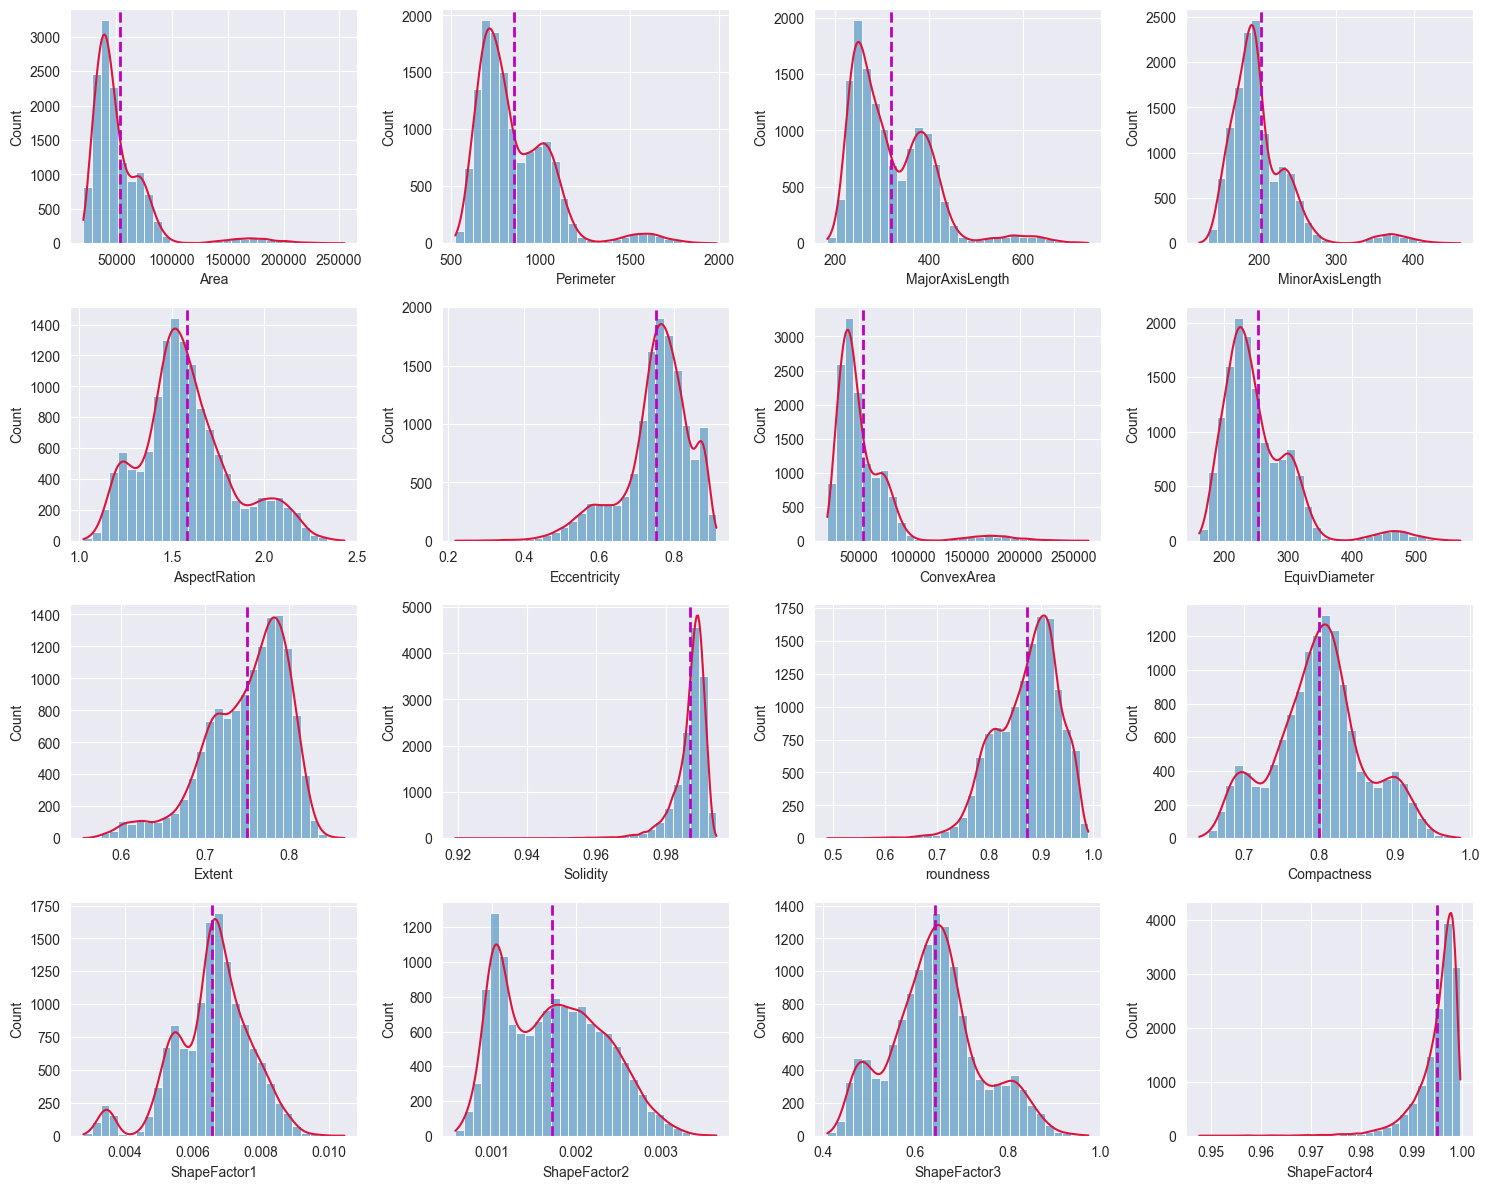

In [5]:
### Verteilung der Daten
Numeric_cols = data.drop(columns=['Class']).columns
fig, ax = plt.subplots(4, 4, figsize=(15, 12))
for variable, subplot in zip(Numeric_cols, ax.flatten()):
    g = sns.histplot(data[variable], bins=30, kde=True, ax=subplot)
    g.lines[0].set_color('crimson')
    g.axvline(x=data[variable].mean(), color='m', label='Mean', linestyle='--', linewidth=2)
plt.tight_layout()

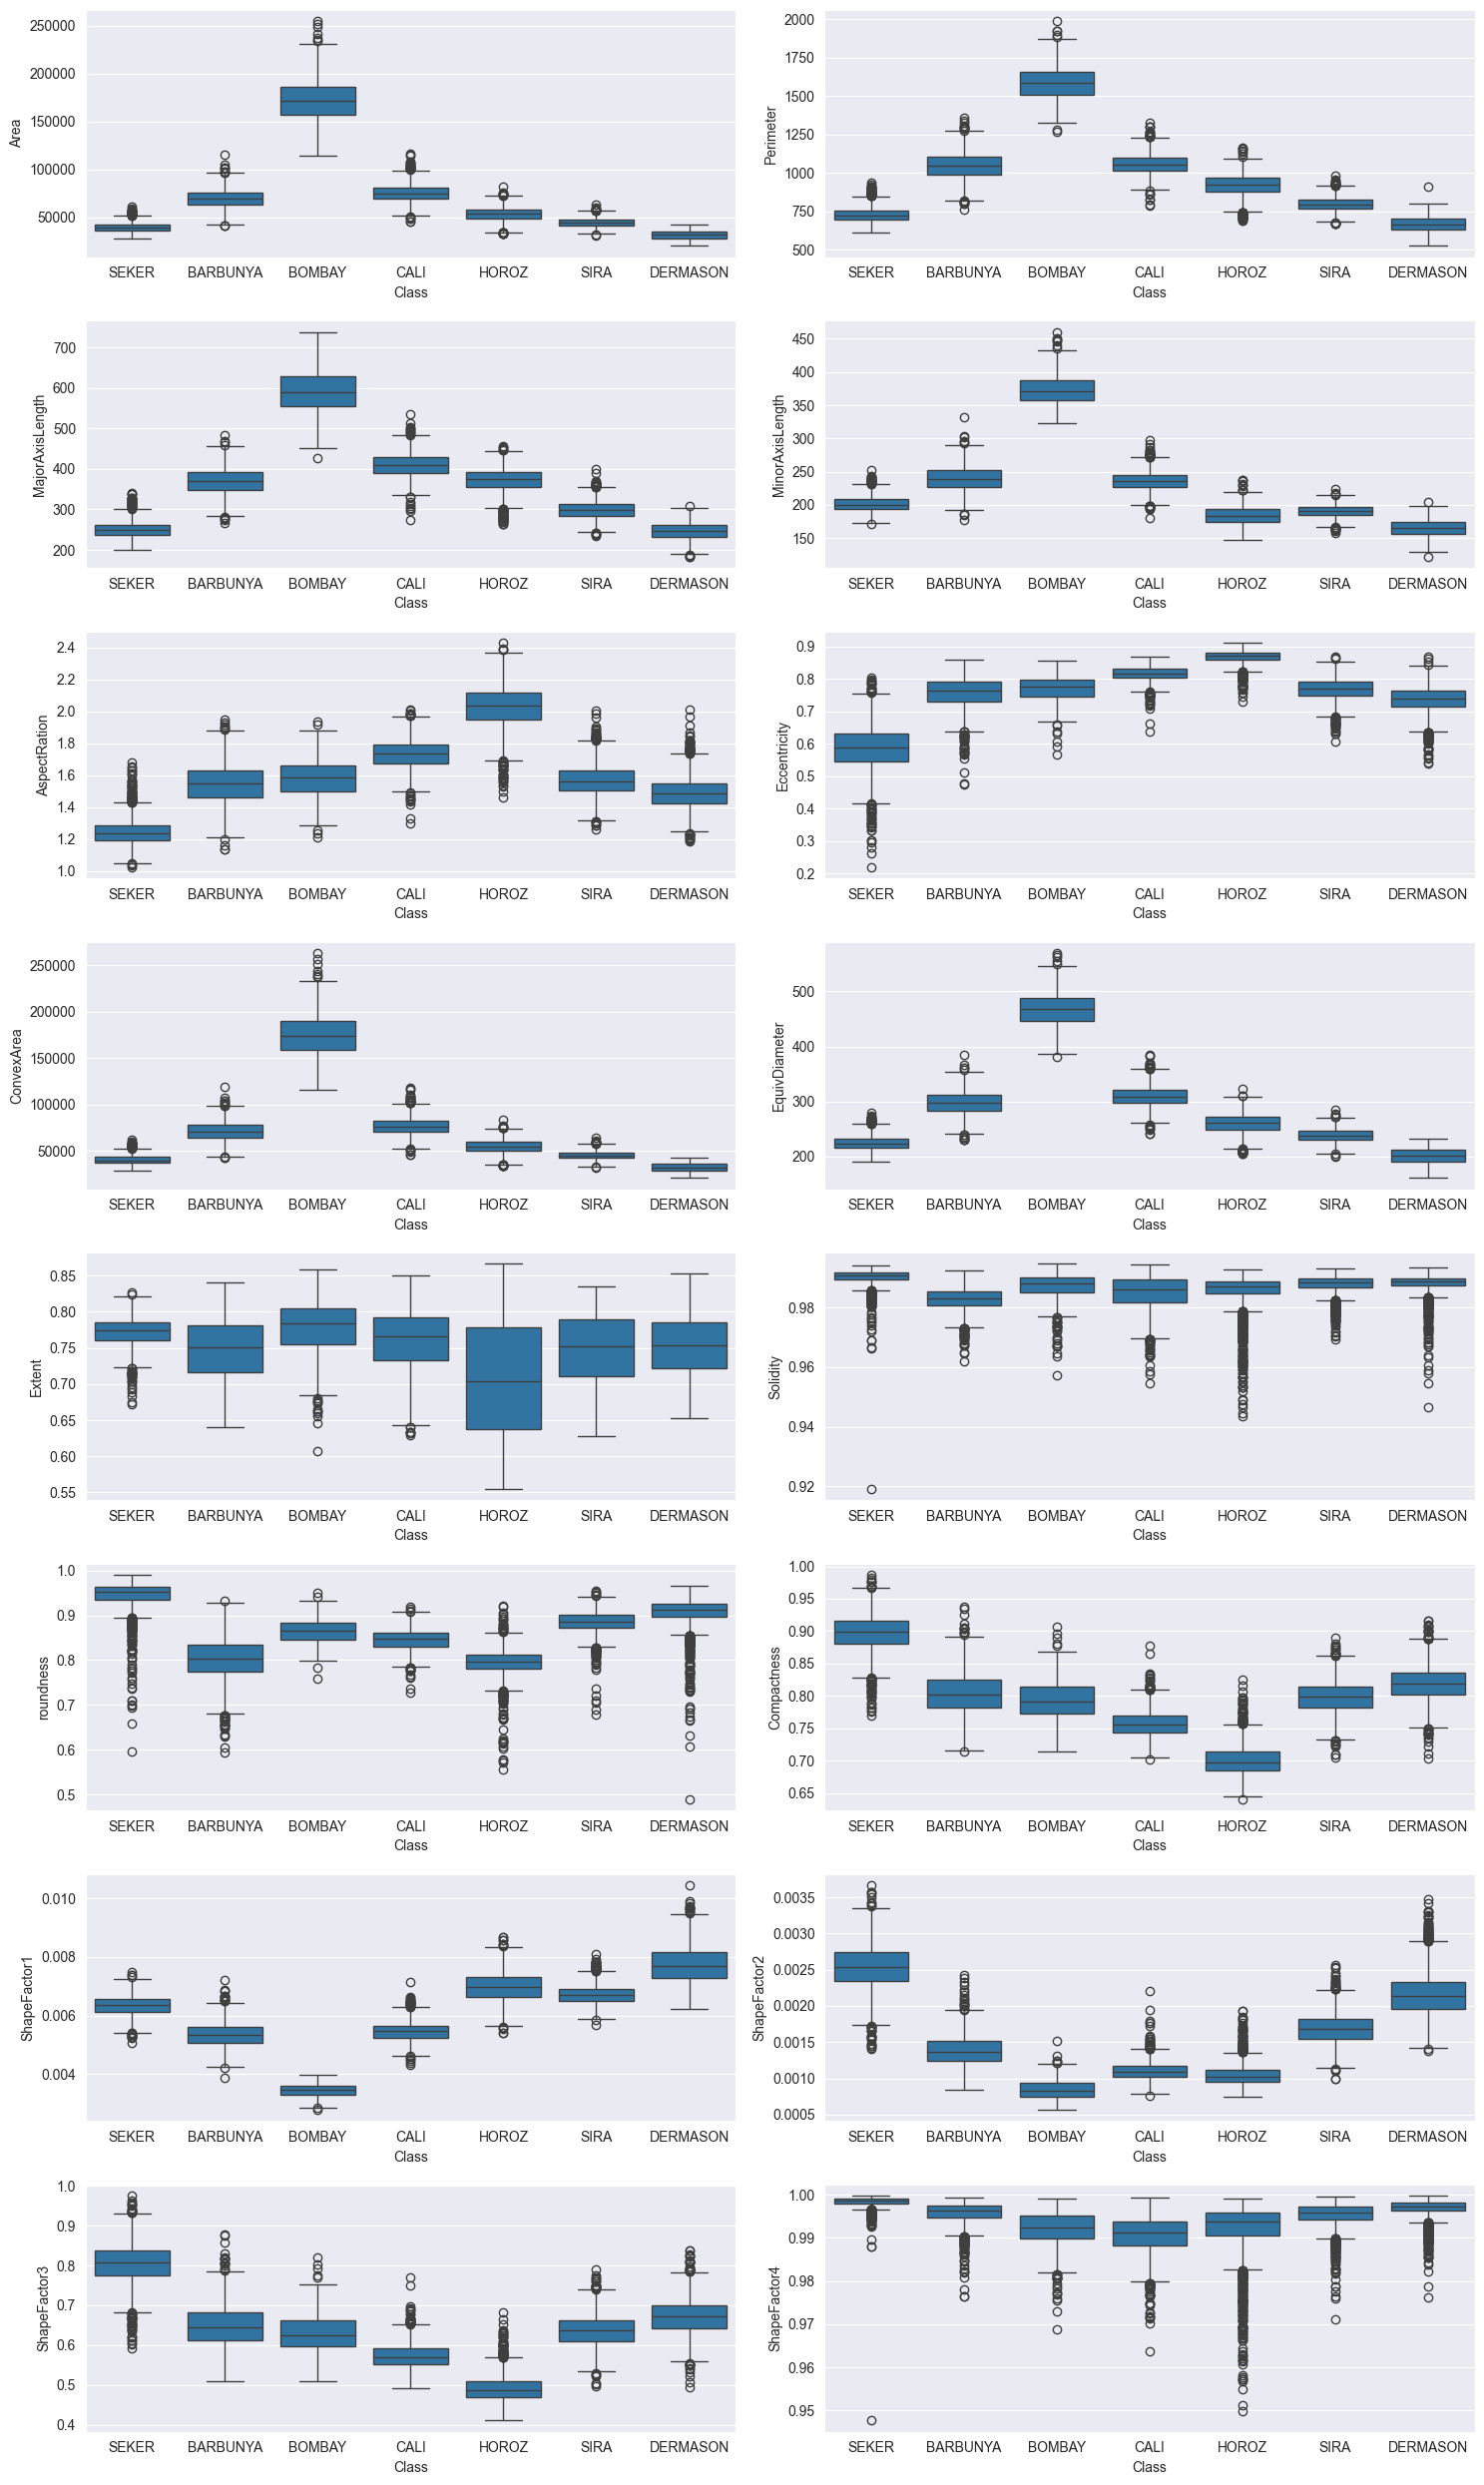

In [6]:
# Boxplots der numerischen Merkmale nach Klasse
fig, ax = plt.subplots(8, 2, figsize=(15, 25))
for variable, subplot in zip(Numeric_cols, ax.flatten()):
    sns.boxplot(x=data['Class'], y=data[variable], ax=subplot)
plt.tight_layout()

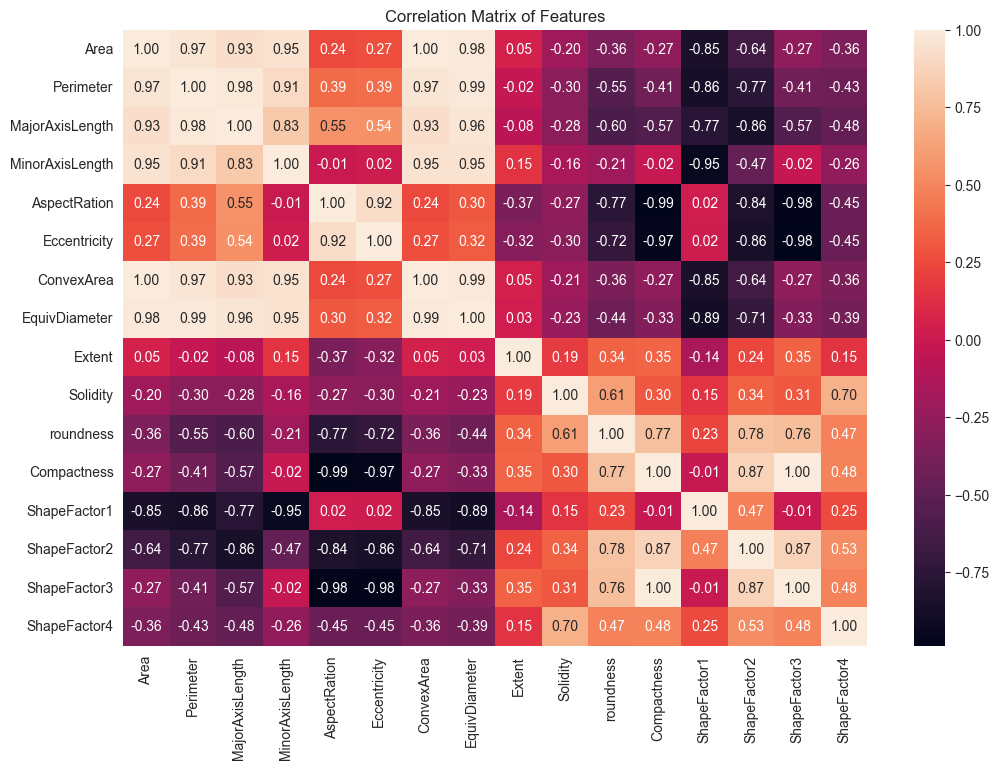

In [7]:
### Korrelationsmatrix

# Numerische Spalten auswählen
numeric_cols = data.select_dtypes(include=[np.number]).columns

# Korrelationen berechnen
correlation_matrix = data[numeric_cols].corr()

# Heatmap erstellen
plt.figure(figsize=[12, 8])
sns.heatmap(correlation_matrix, annot=True, fmt='.2f')
plt.title('Correlation Matrix of Features')
plt.show()

# DNN

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Attention
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt



In [9]:
# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# One-hot encode the labels
y_one_hot = to_categorical(y_encoded)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_one_hot, test_size=0.2, random_state=42)

### Modell aus der Literatur

In [183]:
model = Sequential()
model.add(Dense(12, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(3, activation='sigmoid'))
model.add(Dense(7, activation='sigmoid'))
model.compile(optimizer="RMSprop", loss='categorical_crossentropy', metrics=['accuracy'])

In [184]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    batch_size=8,
    epochs=50,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

Epoch 1/50
1361/1361 [==============================] - 8s 5ms/step - loss: 1.4951 - accuracy: 0.4051 - val_loss: 1.1724 - val_accuracy: 0.4954
Epoch 2/50
1361/1361 [==============================] - 7s 5ms/step - loss: 1.0011 - accuracy: 0.6532 - val_loss: 0.8656 - val_accuracy: 0.7723
Epoch 3/50
1361/1361 [==============================] - 6s 4ms/step - loss: 0.7657 - accuracy: 0.8227 - val_loss: 0.6864 - val_accuracy: 0.8358
Epoch 4/50
1361/1361 [==============================] - 6s 5ms/step - loss: 0.6308 - accuracy: 0.8262 - val_loss: 0.5825 - val_accuracy: 0.8285
Epoch 5/50
1361/1361 [==============================] - 7s 5ms/step - loss: 0.5526 - accuracy: 0.8382 - val_loss: 0.5247 - val_accuracy: 0.8204
Epoch 6/50
1361/1361 [==============================] - 7s 5ms/step - loss: 0.5048 - accuracy: 0.8389 - val_loss: 0.4885 - val_accuracy: 0.8469
Epoch 7/50
1361/1361 [==============================] - 7s 5ms/step - loss: 0.4740 - accuracy: 0.8583 - val_loss: 0.4616 - val_accuracy:

### Selbst erstelltes Modell

In [10]:
# Datenaufteilung
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# One-Hot-Encoding der Labels
y_train_encoded = to_categorical(pd.factorize(y_train)[0])
y_test_encoded = to_categorical(pd.factorize(y_test)[0])

In [11]:
model = Sequential()

model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))

# Hidden Layers (mindestens 10 Schichten)
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3)) 

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))

model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

# Ausgangsschicht (Anzahl der Klassen = 7, softmax für Multiklassen-Klassifikation)
model.add(Dense(y_train_encoded.shape[1], activation='softmax'))

# Modell kompilieren
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [12]:
# Frühzeitiges Stoppen, um Overfitting zu vermeiden
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train_encoded, epochs=100, batch_size=8, validation_split=0.2)

Epoch 1/100
1089/1089 [==============================] - 16s 13ms/step - loss: 1.0424 - accuracy: 0.6312 - val_loss: 0.3220 - val_accuracy: 0.8981
Epoch 2/100
1089/1089 [==============================] - 14s 13ms/step - loss: 0.7057 - accuracy: 0.7852 - val_loss: 0.2892 - val_accuracy: 0.9040
Epoch 3/100
1089/1089 [==============================] - 14s 13ms/step - loss: 0.6260 - accuracy: 0.8114 - val_loss: 0.2842 - val_accuracy: 0.9128
Epoch 4/100
1089/1089 [==============================] - 14s 13ms/step - loss: 0.5998 - accuracy: 0.8210 - val_loss: 0.3025 - val_accuracy: 0.9086
Epoch 5/100
1089/1089 [==============================] - 14s 13ms/step - loss: 0.5255 - accuracy: 0.8455 - val_loss: 0.2875 - val_accuracy: 0.9187
Epoch 6/100
1089/1089 [==============================] - 14s 13ms/step - loss: 0.5370 - accuracy: 0.8443 - val_loss: 0.2741 - val_accuracy: 0.9160
Epoch 7/100
1089/1089 [==============================] - 15s 14ms/step - loss: 0.5158 - accuracy: 0.8456 - val_loss: 0

KeyboardInterrupt: 

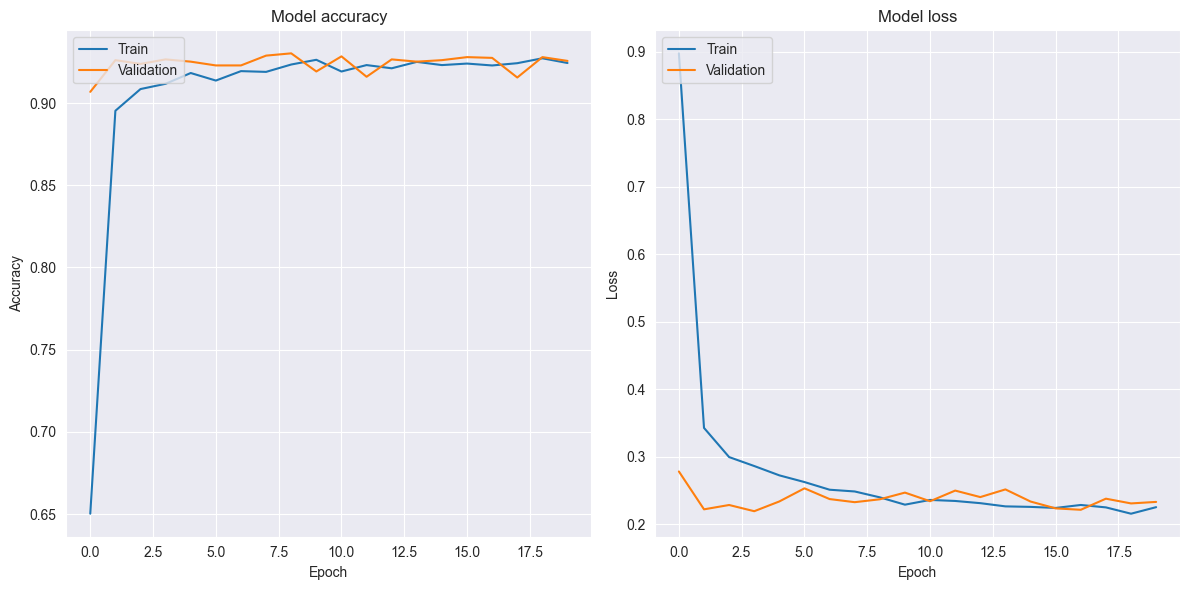

In [188]:
# Plot training history
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# Decision Trees

In [190]:
# Daten splitten (Falls dies nicht bereits oben gemacht wurde)
## Skalierte Daten: 
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

## Unskalierte Daten:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [191]:
# Decision Tree instanziieren
clf = DecisionTreeClassifier()

# Trainieren des Entscheidungsbaums
clf = clf.fit(X_train, y_train)

# Vorhersage der Antwort auf den Testdaten
y_pred = clf.predict(X_test)

# Modellgenauigkeit
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.8920308483290489


In [192]:
## plot speichern (aktuell sehr unübersichtlich)

from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = columns,class_names=data['Class'].unique())
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('decision_tree.png')



KeyboardInterrupt



# Support vector machines

**Support Vector Machine (SVM)** ist ein Klassifikationsalgorithmus. Er findet die beste Hyperplane im n-dimensionalen Raum, die Datenpunkte verschiedener Klassen trennt. Diese Linie maximiert die Margin zwischen den nächsten Datenpunkten der verschiedenen Support Vectors (daher der Name). SVM kann verschiedene Kernel verwenden, um Daten in höhere Dimensionen zu transformieren, falls sie nicht linear trennbar sind. In diesem Beispiel wird ein linearer Kernel verwendet.


In [193]:
# Imports
from sklearn import svm
from sklearn import metrics

In [194]:
# Daten splitten (Falls dies nicht bereits oben gemacht wurde)
## Skalierte Daten: 
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

## Unskalierte Daten:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [195]:
# Erstellen eines SVM-Klassifikators
clf = svm.SVC(kernel='poly', C=1.0, gamma=0.1)

# Training des Modells mit den Trainingsdaten
clf.fit(X_train, y_train)

# Vorhersage der Antworten für den Testdaten
y_pred = clf.predict(X_test)

# Modellgenauigkeit
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.922879177377892


# K-Nearest

In [196]:
# Notwendige Bibliotheken und Module importieren
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [197]:
# Daten splitten (Falls dies nicht bereits oben gemacht wurde)
## Skalierte Daten: 
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

## Unskalierte Daten:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [198]:
# KNN Testing
## Initialisierung des KNeighborsClassifier mit 3 Nachbarn und Modellanpassung auf die Trainingsdaten
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

## Vorhersagen auf den Testdaten machen
y_pred = knn.predict(X_test)

## Genauigkeit des Modells berechnen und ausgeben
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9258171134777818


In [201]:
# Initialisierung des Arrays damit die Scores entsprechend skaliert werden können.
k_values = [i for i in range(1, 31)]
scores = []

# Merkmale skalieren
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Schleife über verschiedene k-Werte
for k in k_values:
    # Initialisierung des KNeighborsClassifier mit dem aktuellen k-Wert
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # Durchführung einer 5-fachen Kreuzvalidierung und Berechnung des durchschnittlichen Genauigkeitswerts
    # Kreuzvalidierung bedeutet, dass der Datensatz in 5 Teile aufgeteilt wird. 
    # Das Modell wird 5 Mal trainiert und getestet, wobei jedes Mal eine andere Teilmenge als Testset verwendet wird.
    # Der durchschnittliche Genauigkeitswert dieser 5 Durchläufe wird berechnet und gespeichert.
    score = cross_val_score(knn, X, y, cv=5)
    scores.append(np.mean(score))


print(max(scores))

0.8687909049183176


Text(0, 0.5, 'Accuracy Score')

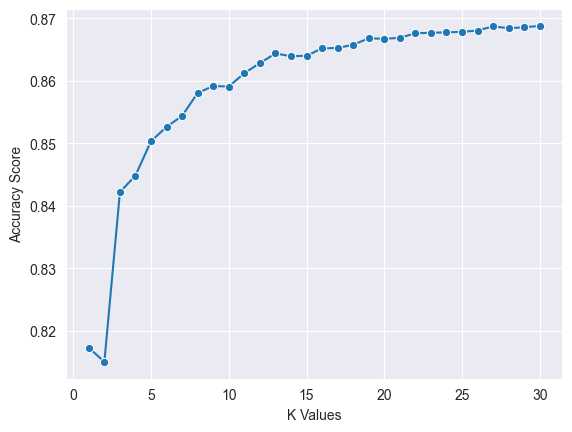

In [202]:
# Resultate Plotten
sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")

Log Reg

In [ ]:
# Imports:
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Daten splitten (Falls dies nicht bereits oben gemacht wurde)
## Skalierte Daten: 
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

## Unskalierte Daten:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# instantiate the model (using the default parameters)
logreg = LogisticRegression(random_state=16)

# fit the model with data
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

In [ ]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

Text(0.5, 427.9555555555555, 'Predicted label')

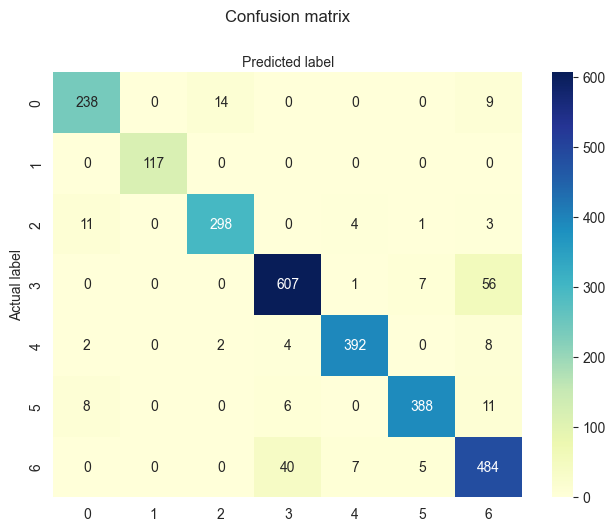

In [174]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')


In [175]:
target_names = data['Class'].unique()
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

       SEKER       0.92      0.91      0.92       261
    BARBUNYA       1.00      1.00      1.00       117
      BOMBAY       0.95      0.94      0.94       317
        CALI       0.92      0.90      0.91       671
       HOROZ       0.97      0.96      0.97       408
        SIRA       0.97      0.94      0.95       413
    DERMASON       0.85      0.90      0.87       536

    accuracy                           0.93      2723
   macro avg       0.94      0.94      0.94      2723
weighted avg       0.93      0.93      0.93      2723

